In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
df

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [3]:
df['week'] = df['time_stamp'].dt.isocalendar().week
df = df.groupby(['week','user_id'])['time_stamp'].count().reset_index(name="freq")

maxvisitsinweek = df.groupby(['user_id'])['freq'].max().reset_index(name='max_visits')

maxvisitsinweek.head()

,user_id,max_visits
0,1,1
1,2,3
2,3,1
3,4,1
4,5,1


In [4]:
df = pd.read_csv('takehome_users.csv', encoding_errors='ignore')
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
df = pd.merge(df, maxvisitsinweek, how='inner', left_on='object_id', right_on='user_id')
df['engaged'] = np.where(df['max_visits'] >= 3, 1, 0)
df = df.drop(columns=['max_visits'])

df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,engaged
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,2,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,3,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,4,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,5,0


In [6]:
df['engaged'].value_counts()

0    7378
1    1445
Name: engaged, dtype: int64

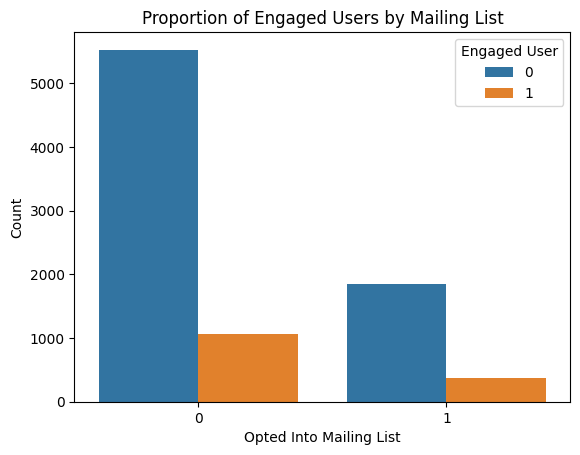

In [7]:
sns.countplot(data=df, x='opted_in_to_mailing_list', hue='engaged')
plt.title('Proportion of Engaged Users by Mailing List')
plt.xlabel('Opted Into Mailing List')
plt.ylabel('Count')
plt.legend(title='Engaged User')

In [8]:
df.loc[df['opted_in_to_mailing_list'] == 1]['engaged'].value_counts()

0    1848
1     378
Name: engaged, dtype: int64

In [9]:
378 / (1848 + 378)

0.16981132075471697

In [10]:
df.loc[df['opted_in_to_mailing_list'] == 0]['engaged'].value_counts()

0    5530
1    1067
Name: engaged, dtype: int64

In [11]:
1067 / (5530 + 1067)

0.1617401849325451

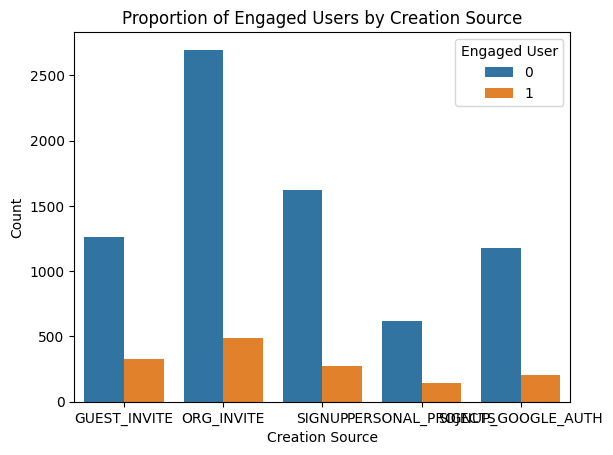

In [12]:
sns.countplot(data=df, x='creation_source', hue='engaged')
plt.title('Proportion of Engaged Users by Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('Count')
plt.legend(title='Engaged User')

In [13]:
df = df[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'engaged']]
df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,engaged
0,GUEST_INVITE,1,0,11,0
1,ORG_INVITE,0,0,1,1
2,ORG_INVITE,0,0,94,0
3,GUEST_INVITE,0,0,1,0
4,GUEST_INVITE,0,0,193,0


In [14]:
df = pd.get_dummies(df, prefix='creation_source', columns=['creation_source'])
df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,engaged,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,0,1,0,0,0,0
1,0,0,1,1,0,1,0,0,0
2,0,0,94,0,0,1,0,0,0
3,0,0,1,0,1,0,0,0,0
4,0,0,193,0,1,0,0,0,0


In [15]:
models = {"Logistic": LogisticRegression(), "RForest": RandomForestClassifier(), "XGBoost": xgb.XGBClassifier()}

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['engaged']), df.engaged, test_size=0.25, random_state=47)

results = []

for model in models.values():

    pipe = make_pipeline(
        model
    )

    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=kf)

    results.append(cv_scores)

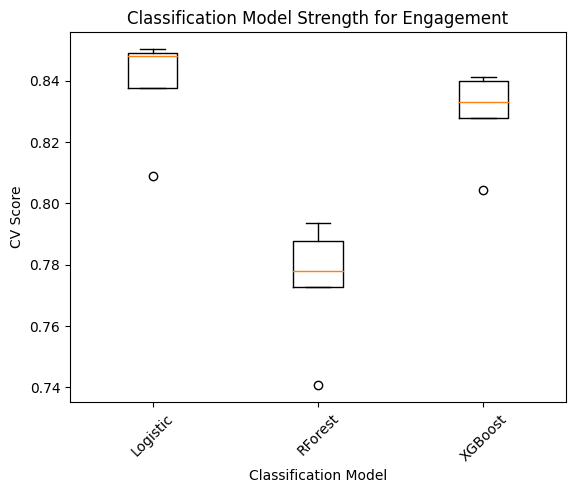

In [16]:
plt.boxplot(results, labels=models.keys())
plt.title("Classification Model Strength for Engagement")
plt.ylabel("CV Score")
plt.xlabel("Classification Model")
plt.xticks(rotation=45)
plt.show()

In [17]:
xgbmodel = xgb.XGBClassifier()

grid_params = {
    'learning_rate' : (0.05, 0.10, 0.15, 0.2, 0.25, 0.3),
    'n_estimators' : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

xgb_grid_cv = GridSearchCV(xgbmodel, param_grid=grid_params, cv=5, n_jobs=-1)
xgb_grid_cv.fit(X_train, y_train)
print(xgb_grid_cv.best_params_)

{'learning_rate': 0.05, 'n_estimators': 100}


In [18]:
y_pred = xgb_grid_cv.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1828
           1       0.00      0.00      0.00       378

    accuracy                           0.83      2206
   macro avg       0.41      0.50      0.45      2206
weighted avg       0.69      0.83      0.75      2206



C:\Users\Andrew\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Andrew\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1

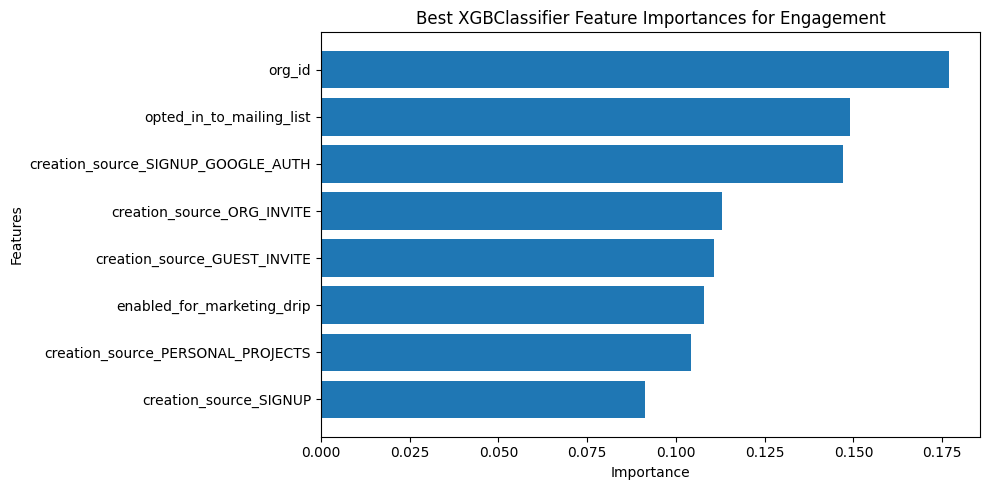

In [20]:
sorted_index = xgb_grid_cv.best_estimator_.feature_importances_.argsort()

plt.subplots(figsize=(10, 5))
plt.barh(X_train.columns[sorted_index], xgb_grid_cv.best_estimator_.feature_importances_[sorted_index])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Best XGBClassifier Feature Importances for Engagement')
plt.tight_layout()